In [1]:
import numpy as np
import cvxpy as cp
#import sklearn
import math

Data columns:  ['cases', 'hospitalizations', 'deaths']
Max Daily Deaths:  4475.0


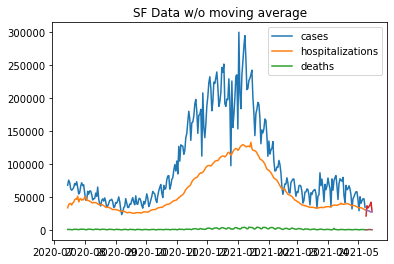

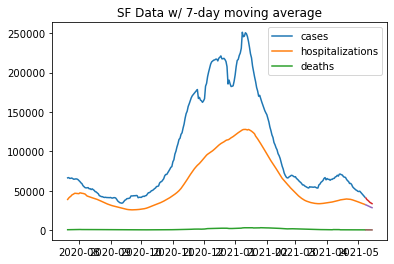

In [2]:
import sys, os
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from src import utils
from src import tuned_estimators as te
from src import gamma_predictions as gp

# load data from processed csv
path_loc = '../datasets/processed/united_states.csv'
data, dates, columns = utils.read_csv(path_loc)
print("Data columns: ", columns)
print("Max Daily Deaths: ", data[:,2].max())

# without averaging

train, test, train_dates, test_dates = utils.train_test_split(data, dates)

plt.figure()
plt.title('SF Data w/o moving average')
plt.plot(train_dates, train)
plt.plot(test_dates, test)
plt.legend(columns)
plt.show()

# with 7-day moving average
mva_data, mva_dates = utils.moving_average(data, dates, days=7)
train, test, train_dates, test_dates = utils.train_test_split(mva_data, mva_dates)

plt.figure()
plt.title('SF Data w/ 7-day moving average')
plt.plot(train_dates, train)
plt.plot(test_dates, test)
plt.legend(columns)
plt.show()


In [3]:
print(columns)
print(train.shape)
print(train[100])

['cases', 'hospitalizations', 'deaths']
(292, 3)
[77360.         41430.57142857   846.42857143]


In [4]:
# size of batch of days we are using
T = 7
# delta = 0.05
# value of lambda for L_1 filtering
lbd = 800

# number of days it takes to get hospitalized from covid
delta1 = 11

# number of days it takes to die from covid
delta2 = 18

# interval of time it takes for infection to 
int_inf = 14

# probability of dying from covid (given disease)
p = 0.02


V = np.zeros(len(train))
U = np.zeros(len(train))
cases_so_far = np.zeros(len(train))

#pred_gammas = np.empty((len(train), 2))
pred_gammas = np.empty((len(train), 4))
complete_gammas = []

# estimate type V active cases for each day and total cases (U + V)
for t in range(delta2, len(train)):
    if t == delta2:
        cases_so_far[t - delta2] = train[t, 2] / p
    else:
        cases_so_far[t - delta2] = cases_so_far[t - delta2 - 1] + train[t, 2] / p
    
    V[t - delta1] = train[t, 1]
    
# estimate type U active cases for each day
for t in range(int_inf + delta2, len(train)):
    U[t - delta2] = cases_so_far[t - delta2] - cases_so_far[t - delta2 - int_inf] - V[t - delta2]



In [123]:
print(complete_gammas[122])

[[0.96034906 0.00201148]
 [0.91701815 0.96430988]]


/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


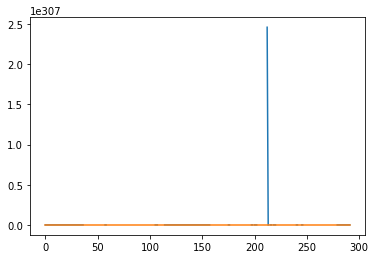

In [4]:
# predict hospitalizations several days ahead

forward = 5
predictions = np.zeros(len(train))

for t in range(T + int_inf + delta2, len(train) - delta1):
    gm = pred_gammas[t]
    nb = U[t - delta2] + V[t - delta2]
    Unext = U[t - delta2]
    Vnext = V[t - delta2]
    for i in range(forward):
        Vnext = gm[0] * Vnext + gm[1] * Unext
        Unext = gm[2] * Vnext + gm[3] * Unext
        nb = Vnext + Unext
    #nb = (gm[0] + gm[1]) * nb
    #predictions[t + 1] = nb * gm[0]
    
    predictions[t + forward + delta1 - delta2] = Vnext



#plt.plot(np.arange(len(train)), predictions / np.amax(predictions))
#plt.plot(np.arange(len(train)), train[:, 1] / np.amax(train[:, 1]))

plt.plot(np.arange(len(train)), predictions)
plt.plot(np.arange(len(train)), train[:, 1])

In [45]:
for i in range(len(predictions)):
    print((predictions[i] - train[i, 1]) / train[i, 1])

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.03150052069877306
0.028330508522097824
0.026462395682093836
0.017179493068508727
0.012519751786252805
0.004940447467843243
0.0007590390286737182
-0.005878828490064186
-0.009604928326141064
-0.013914744184545979
-0.01829210712095712
-0.01723758521236211
-0.013902329725848947
-0.015253538754644129
-0.0139458607557941
-0.009834053062242243
-0.006230907915333125
-0.004792821325617077
0.0008656549257998397
0.0005941572664702658
0.003640743433802232
0.004364559922495189
0.0013132858880944872
-0.0004185621516161207
0.054885724986453735
-0.004899580646103647
-0.010637651590601451
-0.015944947629331387
-0.022044083141020573
-0.02842174396498164
-0.03415642190843107
-0.03865879479287431
-0.03503351019696487
-0.03363344814721191
-0.033454026971917634
-0.03302516980874903
-0.030425483986620865
-0.02865018113104106
-0.0

In [41]:
# estimate gammas 

pred_gammas = np.empty((len(train), 4))

for t in range(T + int_inf + delta2, len(train)):
    u = U[t - T - delta2:t - delta2]
    v = V[t - T - delta2:t - delta2]
    gm = tuned_estimators.estimate_params4(v, u)
    #print(gm)
    complete_gammas.append(gm)
    pred_gammas[t] = gm.flatten()
    

In [9]:
# estimate gammas with l1 penalty
lbd = 400
pred_gammas = np.empty((len(train), 4))
complete_gammas = []

for t in range(T + int_inf + delta2, len(train)):
    u = U[t - T - delta2:t - delta2]
    v = V[t - T - delta2:t - delta2]
    gm = tuned_estimators.l1_estimate_params4(v, u, lbd)
    #print(gm)
    complete_gammas.append(gm)
    pred_gammas[t] = gm[T-2].flatten()
    

In [32]:
pred_gammas[120]

array([0.95292521, 0.00331104, 0.99858815, 0.97010938])

In [5]:
def gamma4_predict_hosp(U, V, pred_gammas, forward, delta1, delta2):
	
	predictions = np.zeros(len(U))

	for t in range(T + int_inf + delta2, len(U) - delta1):
		gm = pred_gammas[t]
		nb = U[t - delta2] + V[t - delta2]
		Unext = U[t - delta2]
		Vnext = V[t - delta2]
		for i in range(forward):
			Vnext = gm[0] * Vnext + gm[1] * Unext
			Unext = gm[2] * Vnext + gm[3] * Unext
			nb = Vnext + Unext
		predictions[t + forward + delta1 - delta2] = Vnext

	return predictions

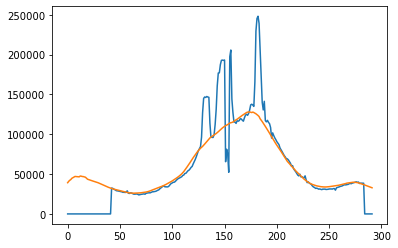

In [5]:
# predict hospitalizations several days ahead

predictions = gamma_predictions.gamma4_predict_hosp(U, V, pred_gammas, 10, delta1, delta2)

plt.plot(np.arange(len(train)), predictions)
plt.plot(np.arange(len(train)), train[:, 1])

In [48]:
for i in range(len(predictions)):
    print((predictions[i] - train[i, 1]) / train[i, 1])

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029862229475031313
0.0219191392117752
0.018424162695372875
-0.0009799483986600282
-0.014512761326653365
-0.03128448981739066
-0.037374540599145176
-0.025394624514785264
-0.02824575612327725
-0.024837446784613828
-0.027166587992996784
-0.032965214612091134
-0.033979737350142966
-0.0168121076476466
-0.02249708957404295
0.012243227465604816
-0.00042516948954114924
-0.018897161154803166
-0.01350816306139328
0.007368426551762155
0.0038269915411663154
-0.021186904147116107
-0.038372746808265155
-0.04874128626184389
-0.04098115658274239
-0.03669249430225649
-0.060361213279579336
-0.09018399871359342
-0.083303935271452
-0.06505037946581411
-0.07290761768459506
-0.07786589040665087
-0.0832495099487704
-0.07637056872028836
-0.06065169523956585
-0.053407006180784936
-0.059872161213951273
-0.06

In [76]:
complete_gammas[135]

array([[0.95585369, 0.00223004, 0.99790663, 0.95268635],
       [0.95543991, 0.00230418, 0.99794723, 0.95403816],
       [0.95506827, 0.00239648, 0.9981159 , 0.95816763],
       [0.95483052, 0.00245415, 0.99874943, 0.97238216],
       [0.95520843, 0.00239075, 0.99905409, 0.97893272],
       [0.95586893, 0.00215653, 0.99922254, 0.98242098],
       [1.        , 1.        , 1.        , 1.        ]])

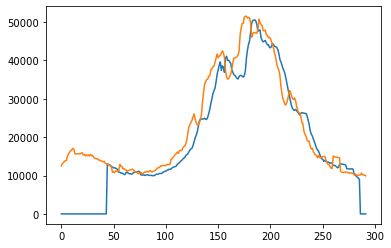

In [8]:
# predict deaths in the future

hor = 5

predictions = gamma_predictions.gamma4_predict_deaths(U, V, pred_gammas, hor, delta1, delta2)

plt.plot(np.arange(len(train)), predictions)
plt.plot(np.arange(len(train)), 15 * train[:, 2])

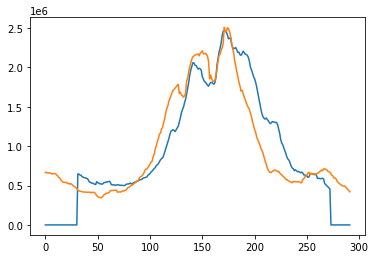

In [12]:
# predict cases into the future

hor = 5

predictions = gamma_predictions.gamma4_predict_cases(U, V, pred_gammas, hor, delta1, delta2)

plt.plot(np.arange(len(train)), predictions)
plt.plot(np.arange(len(train)), 10 * train[:, 0])

In [5]:
# estimate gammas with delta constraint
delta = 0.02
pred_gammas = np.empty((len(train), 4))
complete_gammas = []

for t in range(T + int_inf + delta2, len(train)):
    u = U[t - T - delta2:t - delta2]
    v = V[t - T - delta2:t - delta2]
    gm = te.delta_estimate_params4(v, u, delta)
    #print(gm)
    complete_gammas.append(gm)
    pred_gammas[t] = gm[T-2].flatten()
    

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


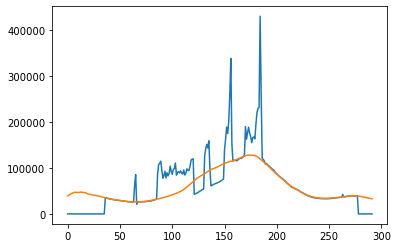

In [8]:
# predict hospitalizations several days ahead

predictions = gp.gamma4_predict_hosp(U, V, pred_gammas, 4, delta1, delta2)

plt.plot(np.arange(len(train)), predictions)
plt.plot(np.arange(len(train)), train[:, 1])

In [7]:
pred_gammas[100]

array([0.93257963, 0.02867606, 1.00061454, 0.96946656])